In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
data = pd.read_pickle('../data/pool_data_clean.pickle')

In [3]:
stable_coins = [
    'FRAX',
    'USDT',
    'USDC',
    'DAI'
]
pools = list(data.keys())
pools

['FRAX-WETH-3000',
 'WETH-USDT-500',
 'USDC-WETH-500',
 'WBTC-USDC-3000',
 'DAI-WETH-500',
 'WETH-USDT-3000',
 'USDC-WETH-3000',
 'DAI-WETH-3000']

In [4]:
def load_minute_data(files):
    dfs = []
    for file in files:
        df = pd.read_csv(file, skiprows=1, index_col=1, parse_dates=['Date'])
        df.sort_index(inplace=True)
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df['ref_value'] = df.loc[:, ['Open', 'High', 'Low', 'Close']].mean(axis=1)
    df = df.resample('1T').last()
    # Uniswap v3 was released in May 2021
    df.drop(df.index[df.index < '2021-05-01'], inplace=True)
    
    return df

In [5]:
# from https://www.cryptodatadownload.com/data/gemini/
eth_min_files = [
    '../data/Gemini_ETHUSD_2021_1min.csv',
    '../data/Gemini_ETHUSD_2022_1min.csv'
]
btc_min_files = [
    '../data/Gemini_BTCUSD_2021_1min.csv',
    '../data/Gemini_BTCUSD_2022_1min.csv'
]

eth_df = load_minute_data(eth_min_files)
btc_df = load_minute_data(btc_min_files)
ref_price_data = {
    'WETH': eth_df,
    'WBTC': btc_df
}

print('ETH')
eth_df.info()
print('\nBTC')
btc_df.info()

ETH
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426423 entries, 2021-05-01 00:00:00 to 2022-02-21 03:02:00
Freq: T
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unix Timestamp  424650 non-null  float64
 1   Symbol          424650 non-null  object 
 2   Open            424650 non-null  float64
 3   High            424650 non-null  float64
 4   Low             424650 non-null  float64
 5   Close           424650 non-null  float64
 6   Volume          424650 non-null  float64
 7   ref_value       424650 non-null  float64
dtypes: float64(7), object(1)
memory usage: 29.3+ MB

BTC
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 426423 entries, 2021-05-01 00:00:00 to 2022-02-21 03:02:00
Freq: T
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unix Timestamp  424670 non-null  float64
 1   Symbol          424670 non-null

In [6]:
def prep_swap_data(swap_df, ref_price_df):
    swap_df.sort_values('swap_time', inplace=True)
    swap_df['swap_time'] = swap_df['swap_time'].dt.tz_localize(None)
    swap_df['swap_time_min'] = swap_df['swap_time'].dt.floor('T')
    swap_df['swap_time_hour'] = swap_df['swap_time'].dt.floor('H')
    swap_df['swap_time_day'] = swap_df['swap_time'].dt.floor('D')

    swap_df = swap_df.merge(ref_price_df.loc[:, ['ref_value']], how='left', 
                            left_on='swap_time_min', right_index=True)
    swap_df['ref_value_low'] = swap_df['ref_value'] * (1 - swap_df['pool_fee'] / 100000)
    swap_df['ref_value_high'] = swap_df['ref_value'] / (1 - swap_df['pool_fee'] / 100000)
    
    asset_token = 0 if swap_df.at[0, 'contract_ticker_symbol_token_0'] not in stable_coins else 1
    swap_df['pool_price'] = swap_df['price_tick_adjusted']
    if asset_token == 1:
        swap_df['pool_price'] = 1 / swap_df['pool_price']
    swap_df['pool_price_prev'] = swap_df['pool_price'].shift(1)

    def is_arbitrage(df):
        if pd.isnull(df['ref_value']):
            return None
        else: 
            return (
                (
                    (df['pool_price_prev'] < df['ref_value_low']) or 
                    (df['pool_price_prev'] > df['ref_value_high'])
                ) and 
                (
                    (df['pool_price'] >= df['ref_value_low']) and 
                    (df['pool_price'] <= df['ref_value_high'])
                )
            )
    swap_df['is_arbitrage'] = swap_df.apply(is_arbitrage, axis=1)
    
    return swap_df

In [7]:
swap_data = {}
for pool, dset in data.items():
    if pool == 'FRAX-WETH-3000':
        continue
    asset = 'WETH' if 'WETH' in pool else 'WBTC'
    swap_df = dset['swaps'].copy()
    swap_df = prep_swap_data(swap_df, ref_price_data[asset])
    swap_data[pool] = swap_df

In [8]:
for pool, swap_df in swap_data.items():
    arb_counts = swap_df['is_arbitrage'].value_counts()
    print(f'{pool}')
    print(f'Estimated Liquidity Swaps: {arb_counts[False]:,.0f}')
    print(f'Estimated Arbitrage Swaps: {arb_counts[True]:,.0f}\n')

WETH-USDT-500
Estimated Liquidity Swaps: 719,768
Estimated Arbitrage Swaps: 11,968

USDC-WETH-500
Estimated Liquidity Swaps: 1,230,550
Estimated Arbitrage Swaps: 10,826

WBTC-USDC-3000
Estimated Liquidity Swaps: 59,203
Estimated Arbitrage Swaps: 45

DAI-WETH-500
Estimated Liquidity Swaps: 283,087
Estimated Arbitrage Swaps: 10,779

WETH-USDT-3000
Estimated Liquidity Swaps: 158,622
Estimated Arbitrage Swaps: 46

USDC-WETH-3000
Estimated Liquidity Swaps: 193,517
Estimated Arbitrage Swaps: 90

DAI-WETH-3000
Estimated Liquidity Swaps: 84,690
Estimated Arbitrage Swaps: 85



The number of arbitrage trades seems very low, but its possible that the liquidity trades move the price in the right direction.

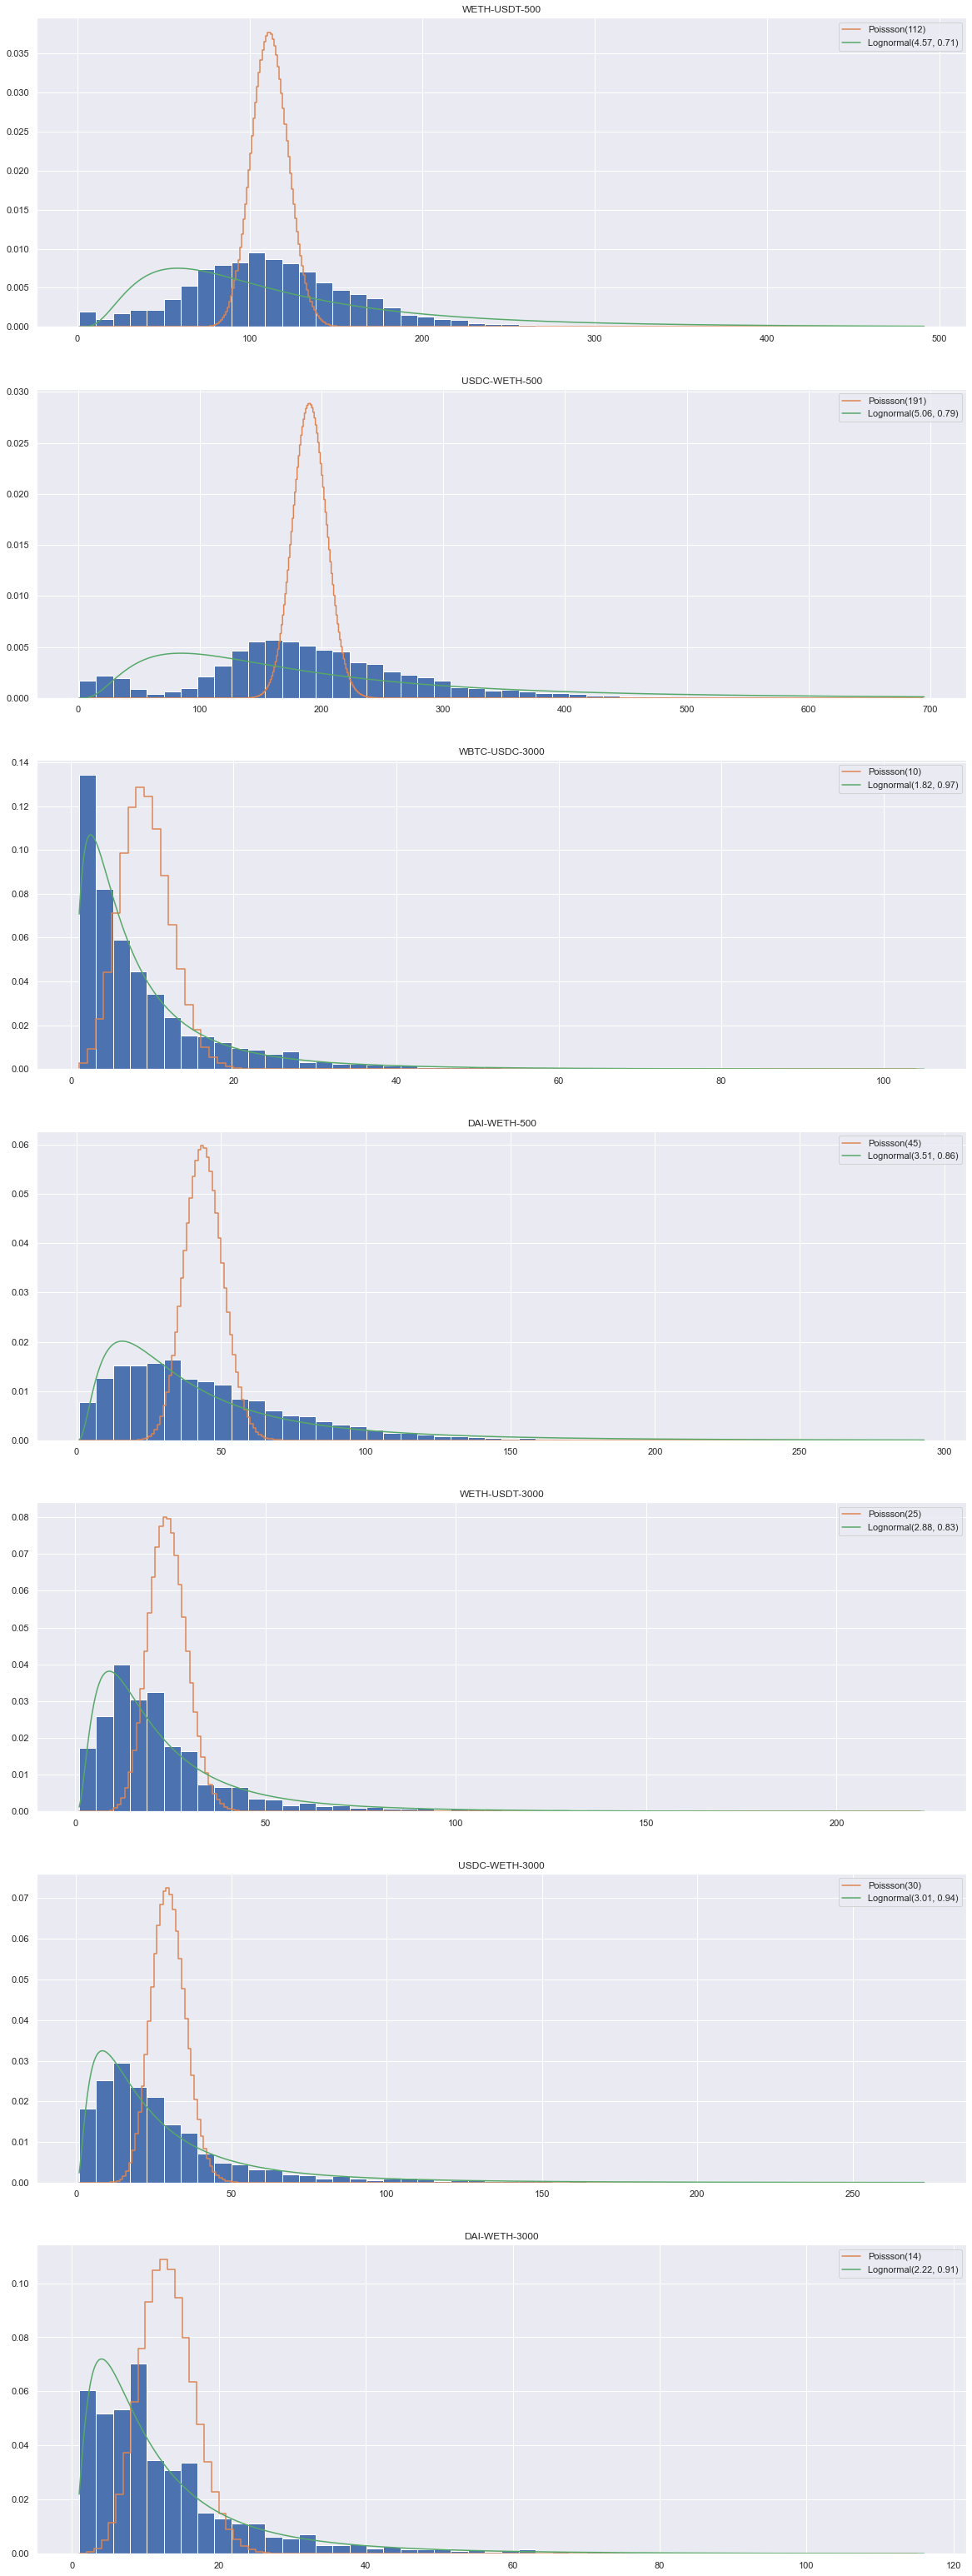

In [9]:
n_plots = len(swap_data.keys())
fig, ax = plt.subplots(n_plots, 1, figsize=(20, n_plots * 8))

for i, (pool, swap_df) in enumerate(swap_data.items()):
    liqu_swaps = swap_df.loc[(~swap_df['is_arbitrage'].fillna(True)), :].copy()
    liqu_swaps['swap_time_hour'] = liqu_swaps['swap_time'].dt.floor('H')
    liqu_swaps_per_hour = liqu_swaps.groupby('swap_time_hour')['tx_hash'].count()
    
    ax[i].hist(liqu_swaps_per_hour, bins=50, density=True)
    
    mu = liqu_swaps_per_hour.mean()
    x = np.arange(liqu_swaps_per_hour.min(), liqu_swaps_per_hour.max())
    y = stats.poisson.pmf(x, mu=mu)
    ax[i].plot(x, y, drawstyle='steps', label=f'Poissson({mu:,.0f})')
    
    params = stats.lognorm.fit(liqu_swaps_per_hour, floc=0)
    x = np.linspace(liqu_swaps_per_hour.min(), liqu_swaps_per_hour.max(), 1000)
    y = stats.lognorm.pdf(x, *params)
    ax[i].plot(x, y, label=f'Lognormal({np.log(params[2]):,.2f}, {params[0]:,.2f})')
    
    ax[i].set_title(f'{pool}')
    ax[i].legend(loc='upper right')
    
plt.show()

Poisson doesn't really fit here... Lognormal does quite well though.

In [10]:
def plot_prices(swap_df, ref_price_df, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))

    swaps = swap_df.set_index('swap_time', drop=True).loc[:, ['pool_price']]
    ax.plot(swaps, label='Pool Price', color='k', linewidth=0.5) 
        
    pool_fees = swap_df.iat[0, swap_df.columns.get_loc('pool_fee')] / 100000
    ref_price_df['ref_value_low'] = ref_price_df['ref_value'] * (1 - pool_fees)
    ref_price_df['ref_value_high'] = ref_price_df['ref_value'] / (1 - pool_fees)

    ax.plot(ref_price_df['ref_value'], label='Reference Value', color='r', linewidth=0.5)
    ax.fill_between(
        ref_price_df.index, 
        ref_price_df['ref_value_low'], 
        ref_price_df['ref_value_high'], 
        alpha=0.25, color='b'
    )
    ref_price_df.drop(['ref_value_low', 'ref_value_high'], axis=1, inplace=True)
    
    ax.legend(loc='upper right')
    
    return ax

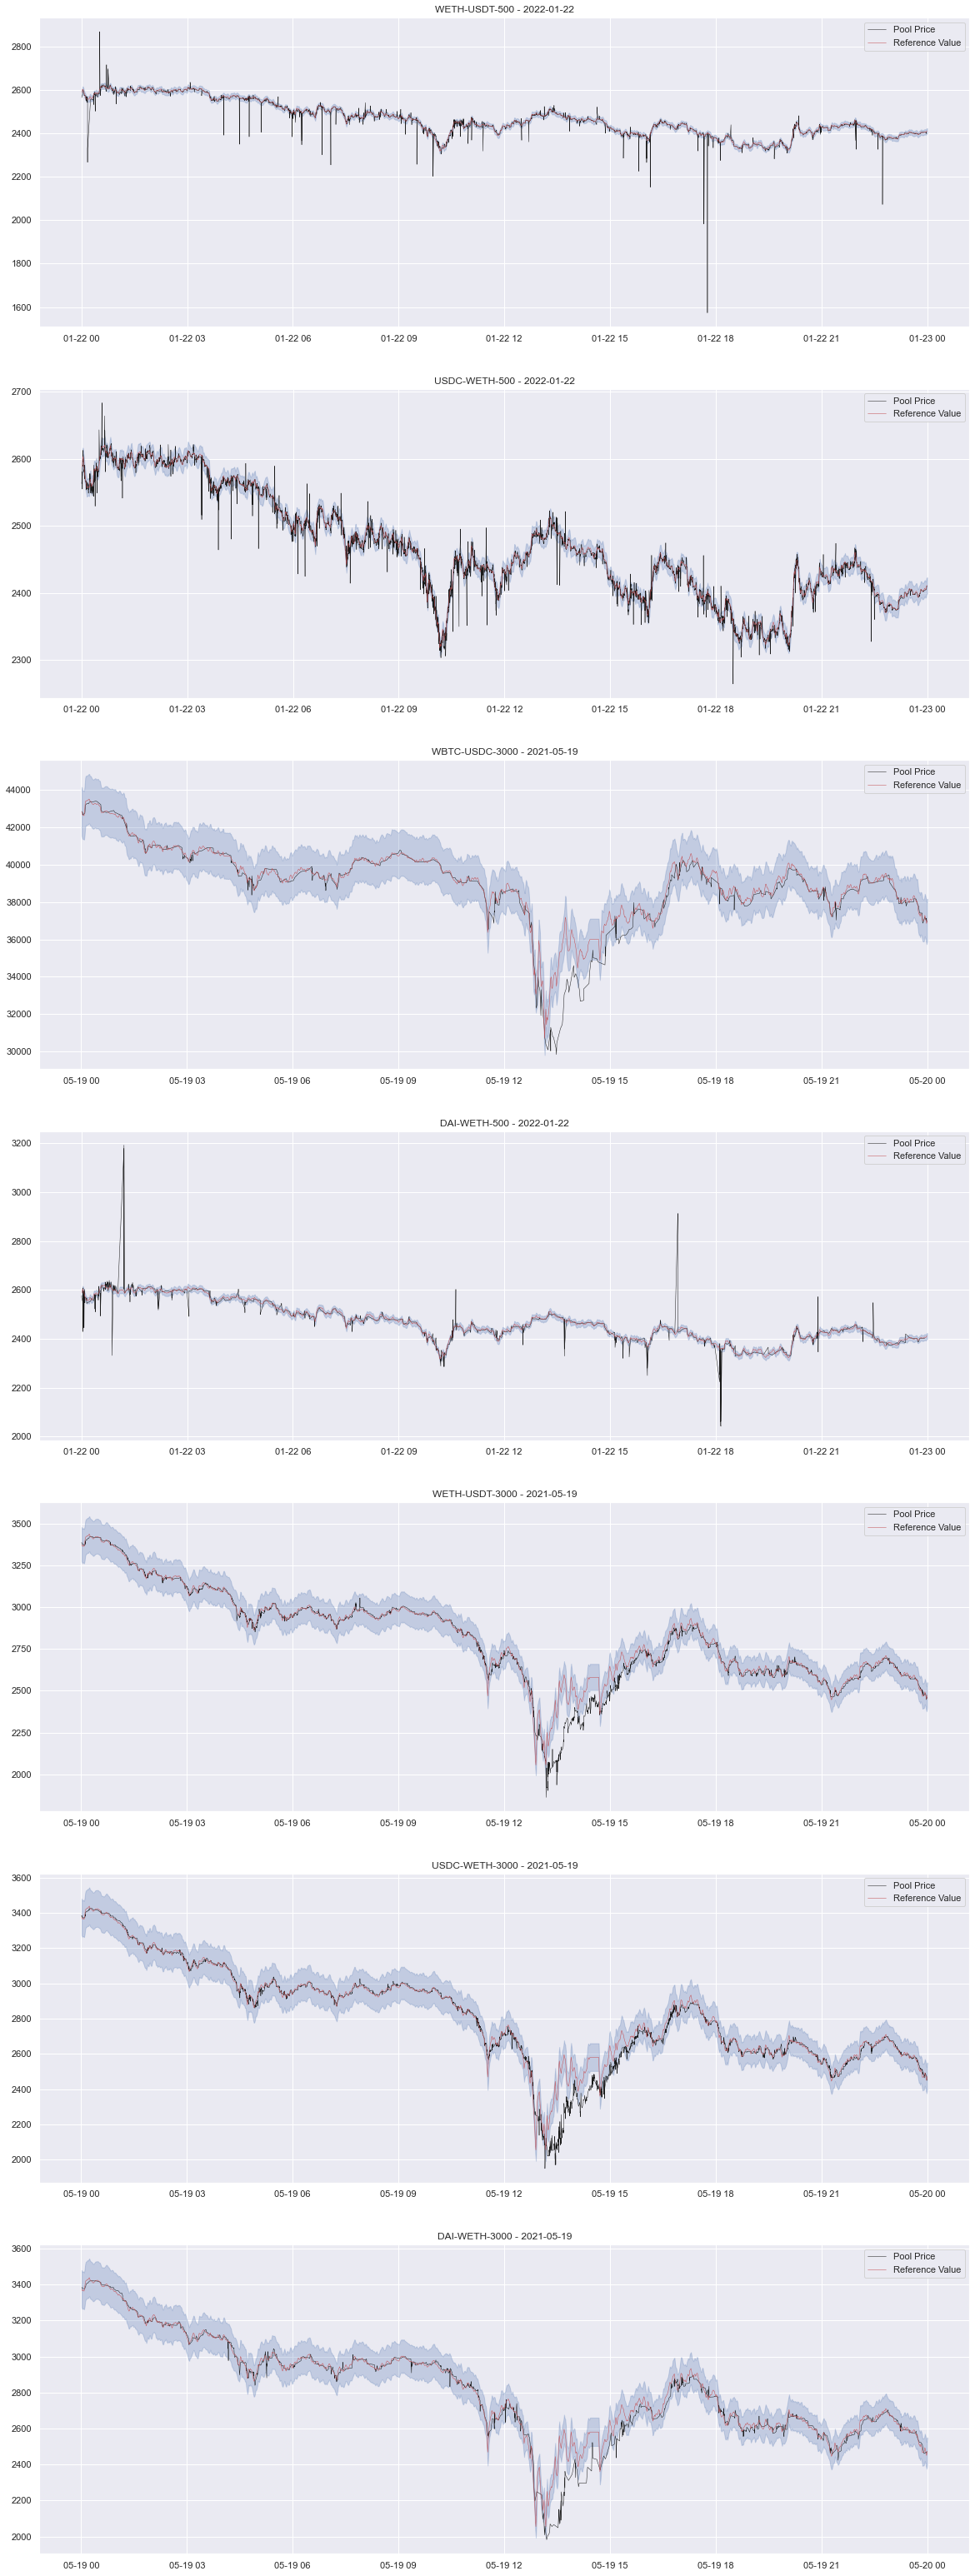

In [11]:
n_plots = len(swap_data.keys())
fig, ax = plt.subplots(n_plots, 1, figsize=(20, n_plots * 8))

for i, (pool, swap_df) in enumerate(swap_data.items()):
    asset = 'WETH' if 'WETH' in pool else 'WBTC'
    ref_price_df = ref_price_data[asset]
    
    day = swap_df.groupby('swap_time_day')['is_arbitrage'].agg(['sum', 'count'])
    day = day.loc[day['count'] > 100]
    if day.shape[0] == 0:
        ax.flatten()[i].set_title(f'{pool}')
        continue
    day = day['sum'].sort_values(ascending=False).index[0]
    
    day_idx = (swap_df['swap_time'] > day) & (swap_df['swap_time'] <= day + pd.DateOffset(days=1))
    swap_df = swap_df.loc[day_idx].copy()

    day_idx = (ref_price_df.index > day) & (ref_price_df.index <= day + pd.DateOffset(days=1))
    ref_price_df = ref_price_df.loc[day_idx].copy()

    plot_prices(swap_df, ref_price_df, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(f'{pool} - {day.strftime("%Y-%m-%d")}')

plt.show()

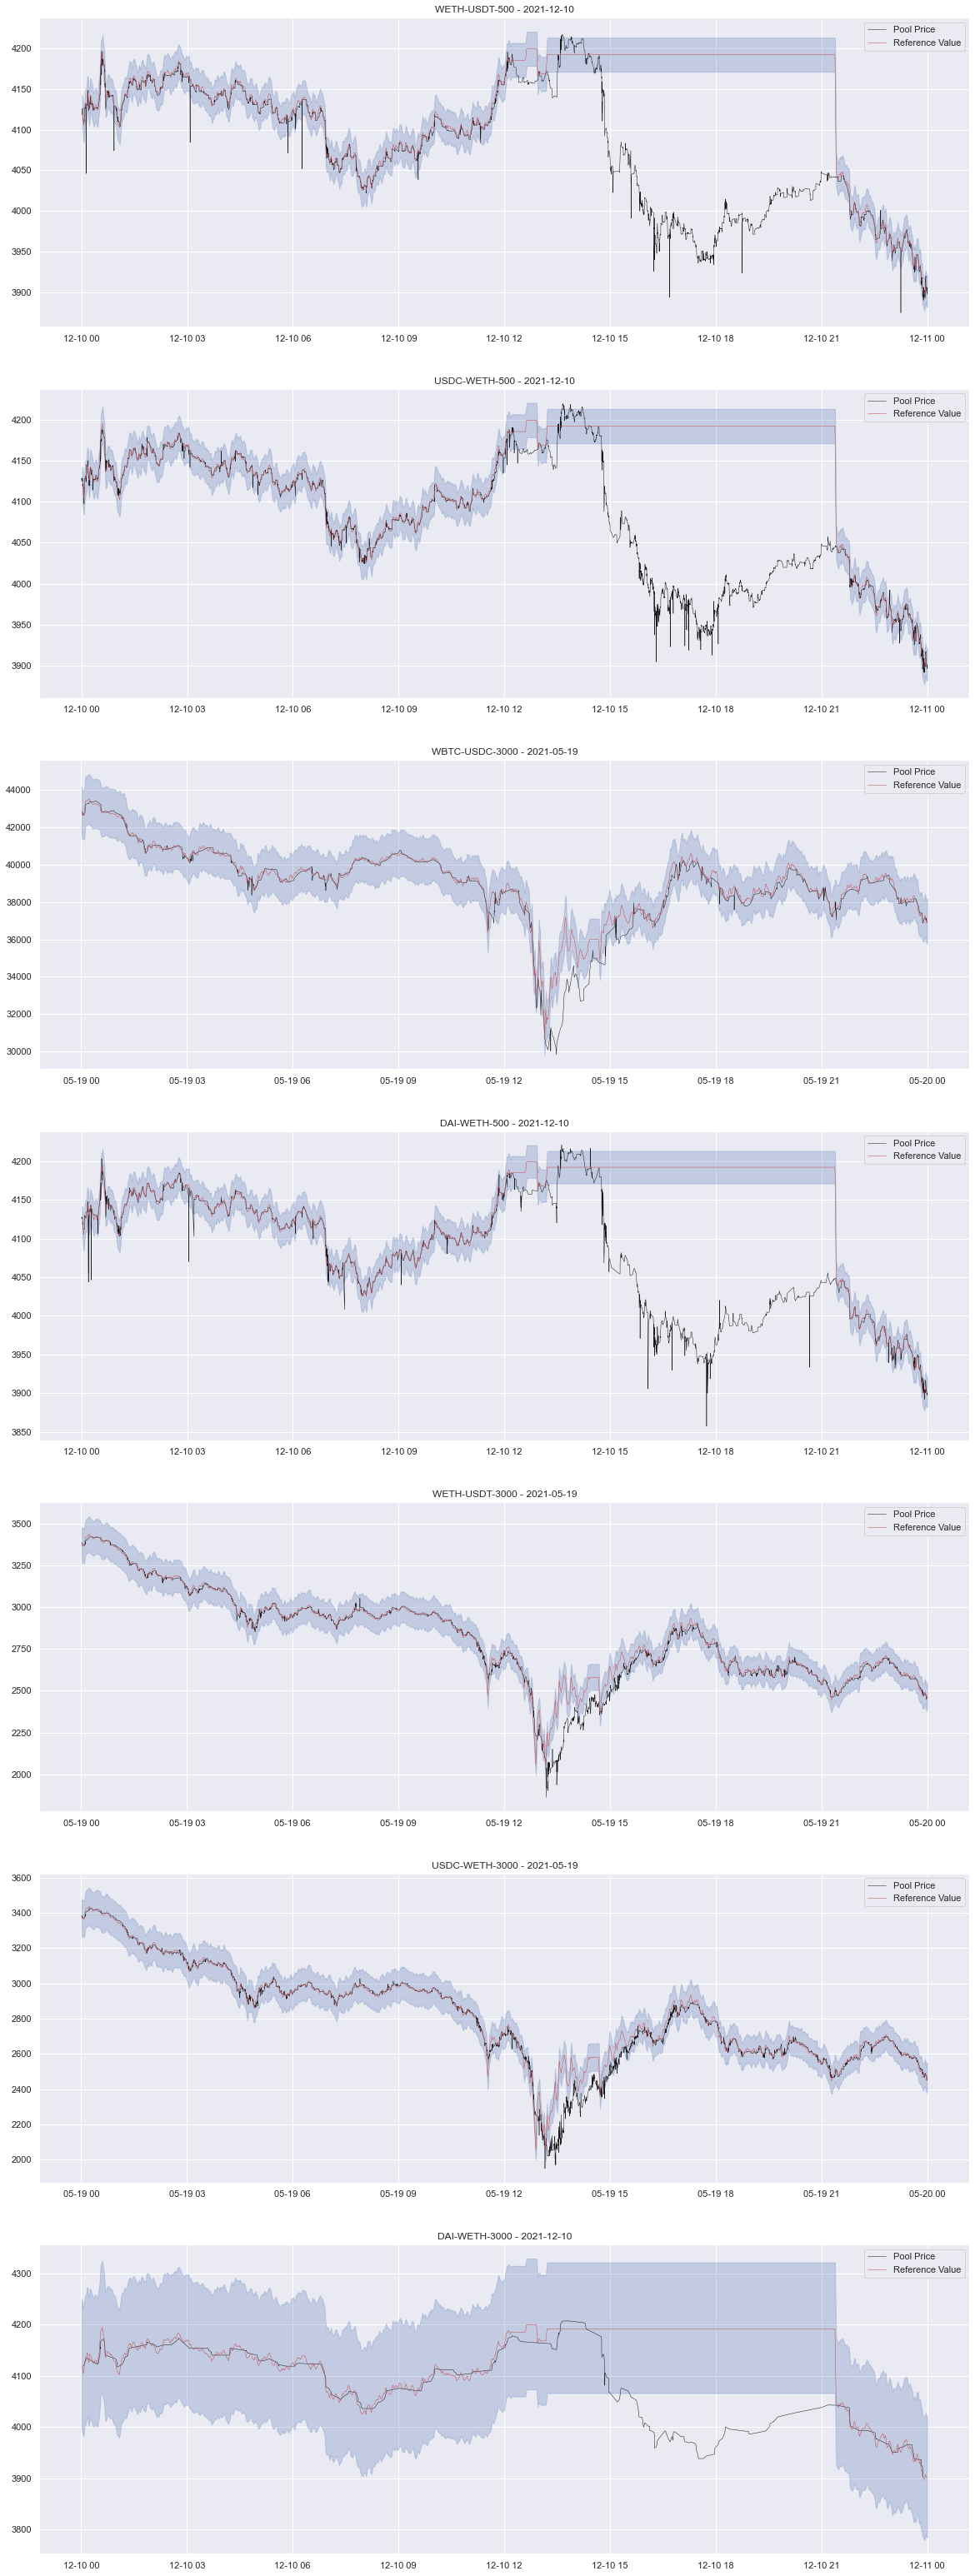

In [19]:
n_plots = len(swap_data.keys())
fig, ax = plt.subplots(n_plots, 1, figsize=(20, n_plots * 8))

for i, (pool, swap_df) in enumerate(swap_data.items()):
    asset = 'WETH' if 'WETH' in pool else 'WBTC'
    ref_price_df = ref_price_data[asset]
    
    swap_df['not_in_price_band'] = (
        (swap_df['pool_price'] > swap_df['ref_value_high']) |
        (swap_df['pool_price'] < swap_df['ref_value_low'])
    )
    
    day = swap_df.groupby('swap_time_day')['not_in_price_band'].agg(['sum', 'count'])
    day = day.loc[day['count'] > 100]
    if day.shape[0] == 0:
        ax.flatten()[i].set_title(f'{pool}')
        continue
    day = day['sum'].sort_values(ascending=False).index[0]
    
    day_idx = (swap_df['swap_time'] > day) & (swap_df['swap_time'] <= day + pd.DateOffset(days=1))
    swap_df = swap_df.loc[day_idx].copy()

    day_idx = (ref_price_df.index > day) & (ref_price_df.index <= day + pd.DateOffset(days=1))
    ref_price_df = ref_price_df.loc[day_idx].copy()

    plot_prices(swap_df, ref_price_df, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(f'{pool} - {day.strftime("%Y-%m-%d")}')

plt.show()

In [12]:
def get_swap_ins(swap_df):
    token0_in = swap_df.loc[swap_df['token_0_amount'] > 0, 'token_0_amount']
    token1_in = swap_df.loc[swap_df['token_1_amount'] > 0, 'token_1_amount']

    token0_prices = swap_df.loc[swap_df['token_0_amount'] > 0, 'price_tick_adjusted']
    token1_prices = swap_df.loc[swap_df['token_1_amount'] > 0, 'price_tick_adjusted']

    token0_idx = swap_df.columns.get_loc('contract_ticker_symbol_token_0')
    asset_token = 0 if swap_df.iat[0, token0_idx] not in stable_coins else 1
    numeraire_token = 0 if swap_df.iat[0, token0_idx] in stable_coins else 1

    if numeraire_token == 0:
        token1_in = token1_in / token1_prices
    else:
        token0_in = token0_in * token0_prices
        
    return token0_in, token1_in

def plot_liquidity_dist(swap_df, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        
    token0_in, token1_in = get_swap_ins(swap_df)

    axes[0].hist(token0_in, bins=100, density=True)
    axes[1].hist(token1_in, bins=100, density=True)

    params = stats.expon.fit(token0_in, floc=0)
    x = np.linspace(token0_in.min(), token0_in.max(), 1000)
    y = stats.expon.pdf(x, *params)
    axes[0].plot(x, y, label=f'Scale={params[1]:,.2f}')
    axes[0].legend(loc='upper right')

    params = stats.expon.fit(token1_in, floc=0)
    x = np.linspace(token1_in.min(), token1_in.max(), 1000)
    y = stats.expon.pdf(x, *params)
    axes[1].plot(x, y, label=f'Scale={params[1]:,.2f}')
    axes[1].legend(loc='upper right')

    return axes

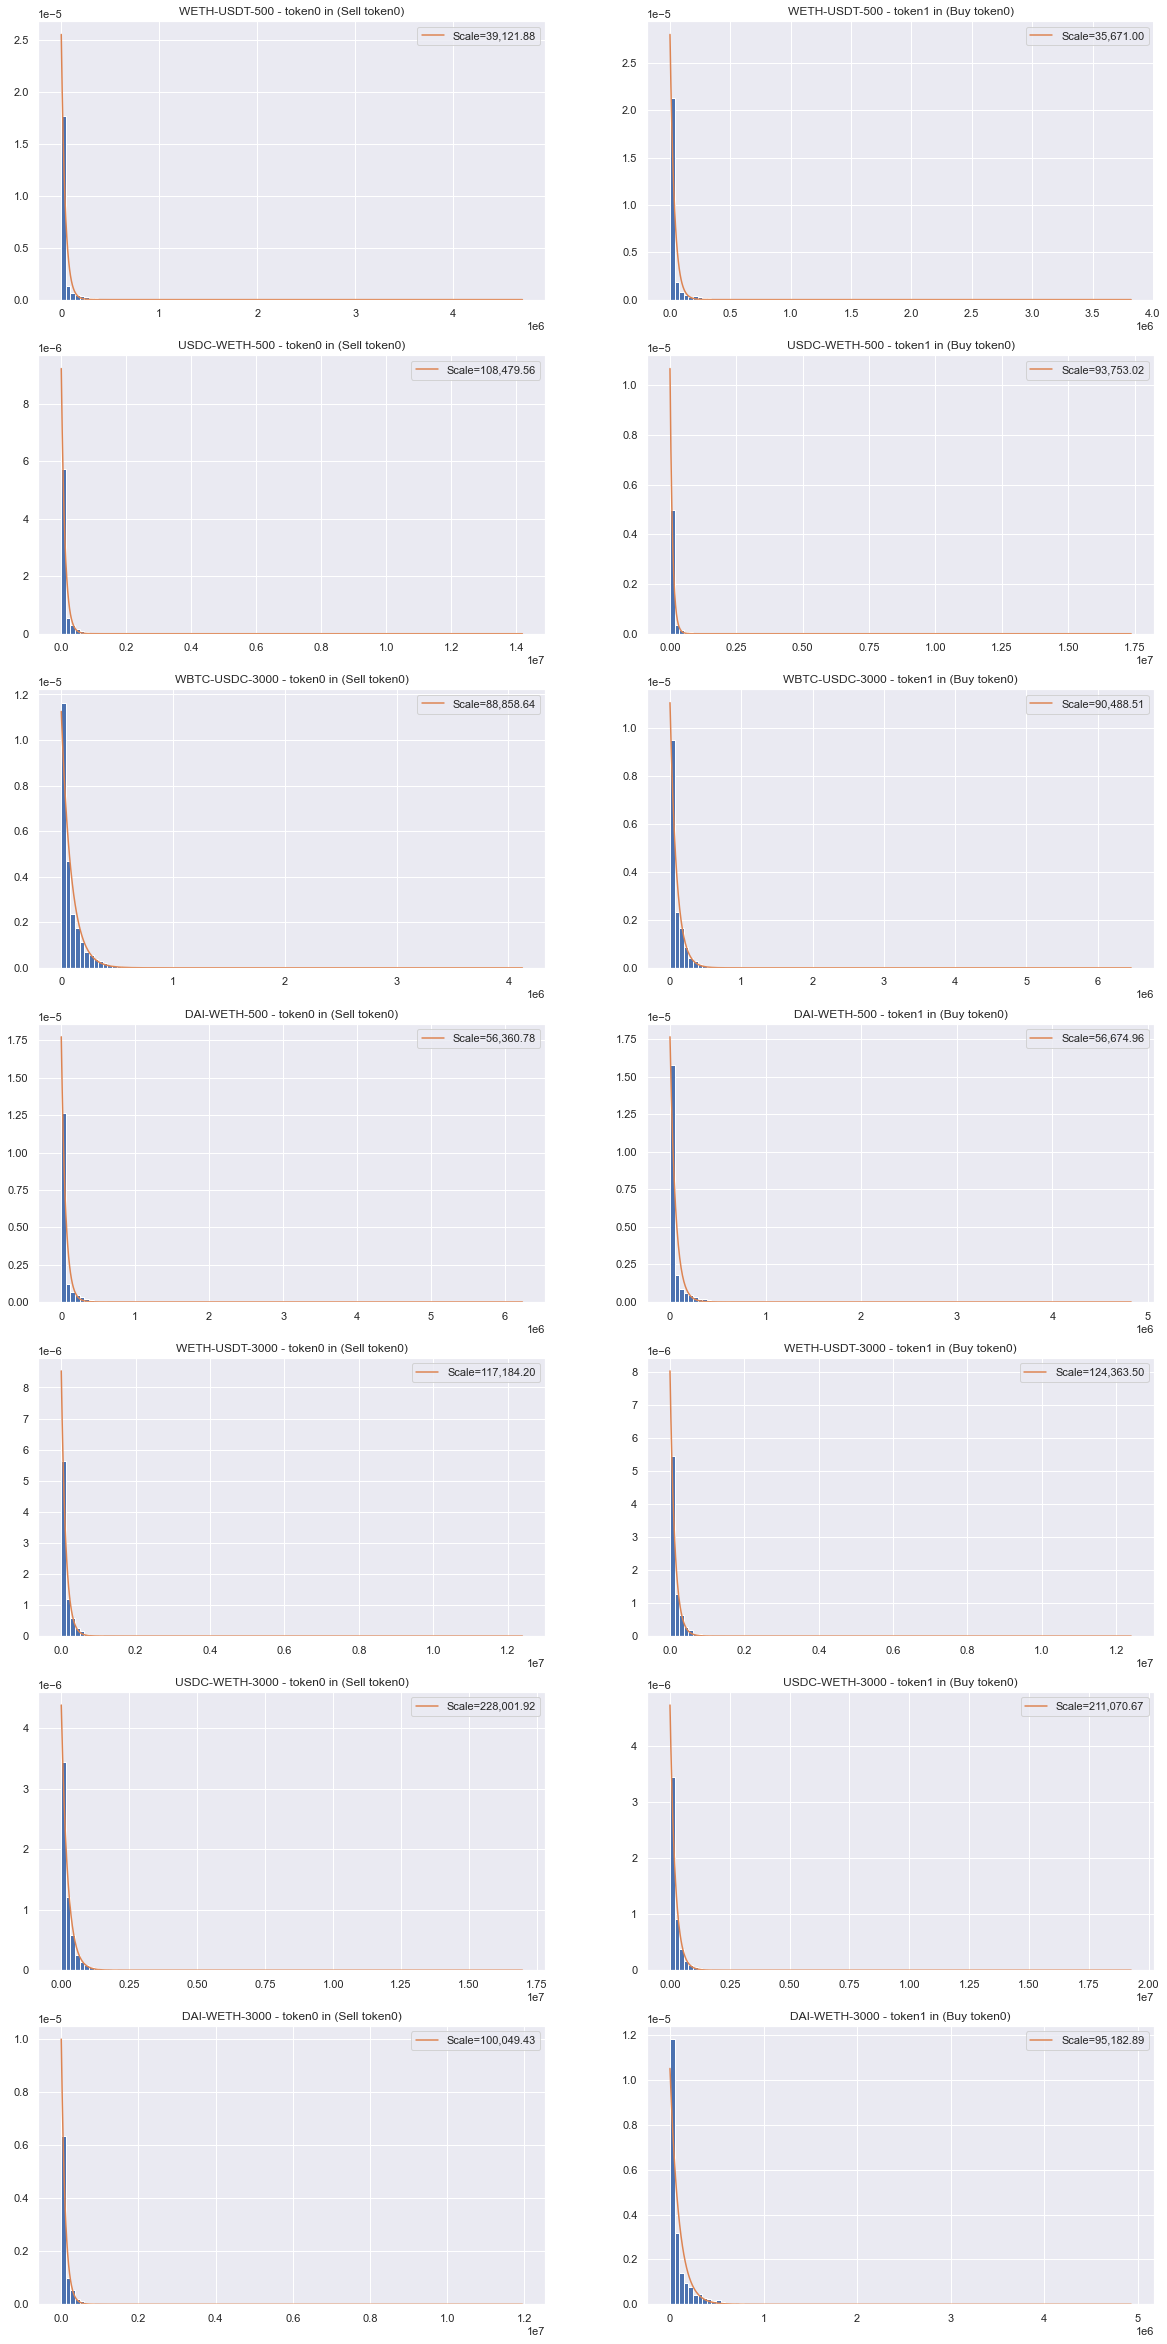

In [13]:
n_plots = len(swap_data.keys())
fig, ax = plt.subplots(n_plots, 2, figsize=(20, n_plots * 6))

for i, (pool, swap_df) in enumerate(swap_data.items()):
    plot_liquidity_dist(swap_df.loc[(~swap_df['is_arbitrage'].fillna(True)), :], 
                        axes=ax[i])
    
    ax[i][0].set_title(f'{pool} - token0 in (Sell token0)')
    ax[i][1].set_title(f'{pool} - token1 in (Buy token0)')

plt.show()